In [147]:
import kagglehub
import os
import random
import skimage.io as skio
import numpy as np
import skimage.measure as skme
import matplotlib.pyplot as plt
from skimage import feature, color
from skimage.transform import hough_line, hough_line_peaks, hough_ellipse, hough_circle, hough_circle_peaks, resize
from skimage.draw import circle_perimeter, line
import random


In [39]:

def max_pooling(image, n):
    return skme.block_reduce(image, block_size=(n, n), func=np.max)


In [ ]:
# Define the dataset path
dataset_path = "/Users/yahyarahhawi/.cache/kagglehub/datasets/jcprogjava/handwritten-digits-dataset-not-in-mnist/versions/4/dataset"

# Initialize an empty dictionary to store arrays for each digit
digit_arrays = {}

# Loop through each digit folder (0, 1, ..., 9)
for digit in range(10):
    digit_folder = os.path.join(dataset_path, str(digit), str(digit))
    
    # Get all image files in the folder
    image_files = [f for f in os.listdir(digit_folder) if f.endswith(".png")]
    
    # Randomly select 10 images
    random_files = random.sample(image_files, 10)
    
    # Load the images into an array
    images = []
    for file in random_files:
        image_path = os.path.join(digit_folder, file)
        image = skio.imread(image_path, as_gray= True)  # Load the image as a numpy array
        images.append(1 - image)
    
    # Convert the list of images into a NumPy array
    digit_arrays[digit] = np.array(images)

# Check the shapes of the arrays for verification
for digit, arr in digit_arrays.items():
    print(f"Digit {digit}: {arr.shape}")

Digit 0: (10, 28, 28)
Digit 1: (10, 28, 28)
Digit 2: (10, 28, 28)
Digit 3: (10, 28, 28)
Digit 4: (10, 28, 28)
Digit 5: (10, 28, 28)
Digit 6: (10, 28, 28)
Digit 7: (10, 28, 28)
Digit 8: (10, 28, 28)
Digit 9: (10, 28, 28)


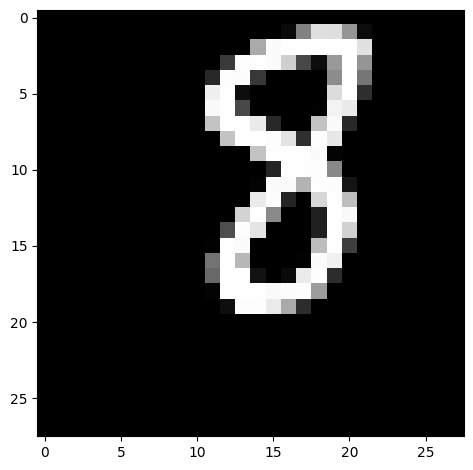

In [199]:
img = digit_arrays[8][8]
#img = max_pooling(img, 2)
skio.imshow(img)

In [218]:
def generate_features(img):
    """
    Generate features for a given digit image. the features include:
    - Hough Line Transform: Extracts the top 3 lines in the image. append (distance, angle, accumulator) for each line
    - Hough Circle Transform: Extracts the top 2 circles in the image. append (center_x, center_y, radius, accumulator) for each circle
    - Combines all features into a 1D array
    """

    # Find the bounding box of the digit
    labeled_img = skme.label(img > 0)  # Label connected regions (non-zero pixels)
    props = skme.regionprops(labeled_img)

    if len(props) == 0:
        print("No object detected in the image.")
        return []

    # Get the bounding box of the largest region (digit)
    largest_region = max(props, key=lambda x: x.area)
    min_row, min_col, max_row, max_col = largest_region.bbox

    # Crop and scale the bounding box to match the original height
    digit_cropped = img[min_row:max_row, min_col:max_col]
    original_height, original_width = img.shape
    cropped_height, cropped_width = digit_cropped.shape
    scale_factor = original_height / cropped_height
    scaled_width = int(round(cropped_width * scale_factor))
    digit_scaled = resize(digit_cropped, (original_height, scaled_width), anti_aliasing=True)

    # Create a blank image of the original size and paste the scaled digit in the center
    scaled_img = np.zeros_like(img, dtype=digit_scaled.dtype)
    offset_x = (original_width - scaled_width) // 2
    if scaled_width <= original_width:
        # Insert scaled digit into the blank image
        scaled_img[:, offset_x:offset_x + scaled_width] = digit_scaled
    else:
        # Resize the digit to exactly fit the original width
        digit_scaled = resize(digit_scaled, (original_height, original_width), anti_aliasing=True)
        scaled_img = digit_scaled

    # Perform Hough Line Transform
    hspace, angles, distances = hough_line(scaled_img)
    hough_lines = list(hough_line_peaks(hspace, angles, distances, num_peaks=3))
    accumulator, angle_peaks, distance_peaks = hough_lines

    # Normalize the line accumulator values
    acc_sum_lines = sum(accumulator)
    normalized_accumulator_lines = [float(acc) / acc_sum_lines for acc in accumulator]

    # Store line features
    line_features = []
    for acc, angle, dist in zip(normalized_accumulator_lines, angle_peaks, distance_peaks):
        line_features.extend([float(dist), float(angle), float(acc)])  # Append as 1D

    # Perform Hough Circle Transform
    min_radius = 2
    max_radius = min(img.shape[0], img.shape[1]) // 2
    radii_range = np.arange(min_radius, max_radius, 2)
    hough_res = hough_circle(scaled_img, radii_range)

    # Extract the top 2 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, radii_range, total_num_peaks=2)

    # Normalize the circle accumulator values
    acc_sum_circles = sum(accums)
    normalized_accums = [float(acc) / acc_sum_circles for acc in accums]

    # Store circle features
    circle_features = []
    for acc, center_x, center_y, radius in zip(normalized_accums, cx, cy, radii):
        circle_features.extend([float(center_x), float(center_y), float(radius), float(acc)])  # Append as 1D

    # Combine all features into a 1D array
    all_features = np.array(line_features + circle_features)

    return all_features

# Example Usage
features = generate_features(img)
print("All Features (1D Vector):", features)

All Features (1D Vector): [18.          0.4712389   0.35353535  1.         -0.78539816  0.32323232
 20.          0.27925268  0.32323232 14.          7.          6.
  0.5        14.         20.          6.          0.5       ]


In [211]:
new_img = max_pooling(img, 2)

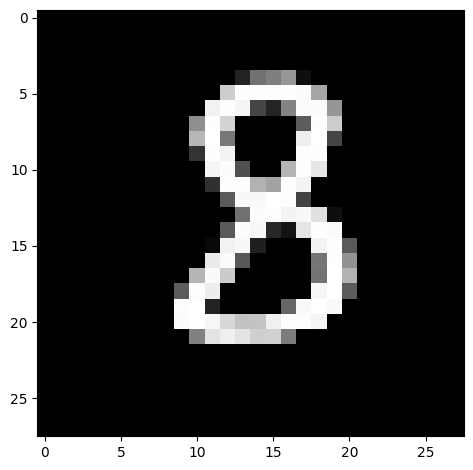

In [212]:
skio.imshow(edges)

In [ ]:
def prepare_dataset(dataset_path, generate_features, num_samples=4000, validation_split=0.2):
    
    digit_features = []
    digit_labels = []

    # Loop through each digit folder (0, 1, ..., 9)
    for digit in range(10):
        digit_folder = os.path.join(dataset_path, str(digit), str(digit))
        
        # Get all image files in the folder
        image_files = [f for f in os.listdir(digit_folder) if f.endswith(".png")]
        
        # Randomly select the required number of images
        random_files = random.sample(image_files, num_samples)
        
        # Generate features for each image
        for file in random_files:
            image_path = os.path.join(digit_folder, file)
            image = skio.imread(image_path, as_gray=True)  # Load the image as grayscale
            image = 1 - image  # Invert the image (optional, depends on generate_features)

            # Generate feature vector
            features = generate_features(image)
            
            if features is not None:  # Ensure valid feature vector
                digit_features.append(features)
                digit_labels.append(digit)

    # Convert features and labels to lists for further processing
    digit_labels = np.array(digit_labels)

    # Determine the maximum length of the feature vectors
    max_length = max(len(f) for f in digit_features)

    # Pad feature vectors to the same length
    padded_features = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in digit_features])

    # Split into training and validation datasets
    num_validation = int(validation_split * num_samples)
    train_features, val_features = [], []
    train_labels, val_labels = [], []

    for digit in range(10):
        digit_idx = np.where(digit_labels == digit)[0]
        train_idx = digit_idx[:-num_validation]
        val_idx = digit_idx[-num_validation:]

        train_features.append(padded_features[train_idx])
        train_labels.append(digit_labels[train_idx])

        val_features.append(padded_features[val_idx])
        val_labels.append(digit_labels[val_idx])

    train_features = np.concatenate(train_features, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    val_features = np.concatenate(val_features, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)

    return (train_features, train_labels), (val_features, val_labels)

# Example Usage
(train_features, train_labels), (val_features, val_labels) = prepare_dataset(dataset_path, generate_features)

print("Training Features Shape:", train_features.shape)
print("Validation Features Shape:", val_features.shape)

Training Features Shape: (32000, 17)
Validation Features Shape: (8000, 17)


In [258]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define a simple neural network
class DigitClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DigitClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model
input_size = train_features.shape[1]
num_classes = 10
model = DigitClassifier(input_size, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Validation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for features, labels in val_loader:
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.2f}")

Epoch 1/50, Loss: 1.2364
Epoch 2/50, Loss: 0.7983
Epoch 3/50, Loss: 0.6566
Epoch 4/50, Loss: 0.5682
Epoch 5/50, Loss: 0.4989
Epoch 6/50, Loss: 0.4459
Epoch 7/50, Loss: 0.4110
Epoch 8/50, Loss: 0.3877
Epoch 9/50, Loss: 0.3591
Epoch 10/50, Loss: 0.3391
Epoch 11/50, Loss: 0.3227
Epoch 12/50, Loss: 0.3060
Epoch 13/50, Loss: 0.2928
Epoch 14/50, Loss: 0.2827
Epoch 15/50, Loss: 0.2746
Epoch 16/50, Loss: 0.2639
Epoch 17/50, Loss: 0.2546
Epoch 18/50, Loss: 0.2496
Epoch 19/50, Loss: 0.2440
Epoch 20/50, Loss: 0.2365
Epoch 21/50, Loss: 0.2326
Epoch 22/50, Loss: 0.2264
Epoch 23/50, Loss: 0.2211
Epoch 24/50, Loss: 0.2161
Epoch 25/50, Loss: 0.2146
Epoch 26/50, Loss: 0.2093
Epoch 27/50, Loss: 0.2032
Epoch 28/50, Loss: 0.2014
Epoch 29/50, Loss: 0.1973
Epoch 30/50, Loss: 0.1948
Epoch 31/50, Loss: 0.1907
Epoch 32/50, Loss: 0.1884
Epoch 33/50, Loss: 0.1864
Epoch 34/50, Loss: 0.1812
Epoch 35/50, Loss: 0.1839
Epoch 36/50, Loss: 0.1782
Epoch 37/50, Loss: 0.1748
Epoch 38/50, Loss: 0.1730
Epoch 39/50, Loss: 0.

Predicted Digit: 9


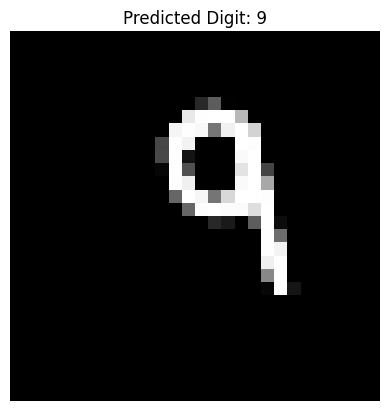

In [271]:

def predict_and_display(image, model, generate_features):
    features = generate_features(image)
    if features is None or len(features) == 0:
        raise ValueError("Feature extraction failed. Ensure the image is valid and `generate_features` works properly.")

    input_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        output = model(input_tensor)  # Get raw predictions (logits)
        _, predicted_label = torch.max(output, 1)  # Get the index of the highest score

    # Step 4: Print and display the predicted digit
    predicted_digit = predicted_label.item()
    print(f"Predicted Digit: {predicted_digit}")

    # Display the image
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted Digit: {predicted_digit}")
    plt.axis("off")
    plt.show()

# Example Usage
predicted_digits = predict_and_display(digit_arrays[9][1], model, generate_features)


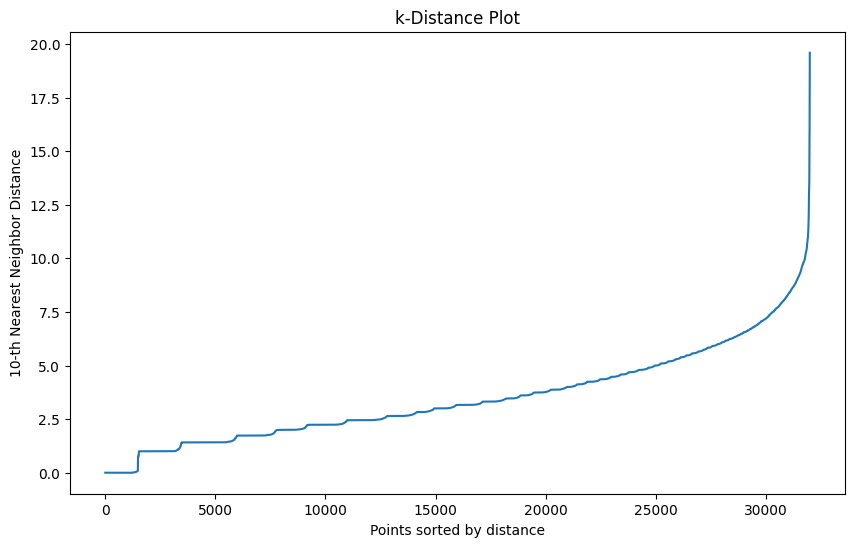

Unique Clusters: [0]
Counts per Cluster: [32000]
Number of Noise Points: 0
K-Means Training ARI: 0.10
K-Means Training AMI: 0.19
K-Means Validation ARI: 0.10
K-Means Validation AMI: 0.19
Logistic Regression Validation Accuracy: 0.63


/Users/yahyarahhawi/miniforge3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [275]:
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Function to evaluate clustering performance
def evaluate_clustering(true_labels, cluster_labels):
    non_noise_idx = cluster_labels != -1  # Exclude noise points (for DBSCAN)
    true_labels_filtered = true_labels[non_noise_idx]
    cluster_labels_filtered = cluster_labels[non_noise_idx]

    ari = adjusted_rand_score(true_labels_filtered, cluster_labels_filtered)
    ami = adjusted_mutual_info_score(true_labels_filtered, cluster_labels_filtered)
    return ari, ami

# Function to predict labels using DBSCAN
def predict_label(new_features, dbscan, train_features, train_labels):
    cluster_labels = dbscan.labels_

    # Map clusters to their most common labels
    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])
    cluster_to_label = {}
    for cluster in unique_clusters:
        cluster_points_idx = np.where(cluster_labels == cluster)[0]
        cluster_labels_mapped = train_labels[cluster_points_idx]
        most_common_label = np.bincount(cluster_labels_mapped).argmax()
        cluster_to_label[cluster] = most_common_label

    # Find nearest neighbors
    nn = NearestNeighbors(n_neighbors=1).fit(train_features)
    distances, indices = nn.kneighbors(new_features)

    # Map neighbors to cluster labels
    nearest_clusters = cluster_labels[indices.flatten()]
    predicted_labels = [
        cluster_to_label[cluster] if cluster in cluster_to_label else -1
        for cluster in nearest_clusters
    ]
    return np.array(predicted_labels)

# Load your dataset (replace with your actual data)
# Assume `train_features`, `train_labels`, `val_features`, `val_labels` are already defined

# Step 1: k-Distance Plot for DBSCAN Parameter Tuning
k = 10
nn = NearestNeighbors(n_neighbors=k)
nn.fit(train_features)
distances, _ = nn.kneighbors(train_features)

# Sort distances and plot
sorted_distances = np.sort(distances[:, k-1])  # k-th nearest neighbor
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title("k-Distance Plot")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.show()

# Choose eps based on the "elbow" point in the plot
eps_value = 300.0  # Adjust this value based on the plot

# Step 2: DBSCAN Clustering
dbscan = DBSCAN(eps=eps_value, min_samples=10)
dbscan.fit(train_features)

train_cluster_labels = dbscan.labels_

# Debug: Check cluster distribution
unique_clusters, counts = np.unique(train_cluster_labels, return_counts=True)
print(f"Unique Clusters: {unique_clusters}")
print(f"Counts per Cluster: {counts}")
print(f"Number of Noise Points: {np.sum(train_cluster_labels == -1)}")

# Step 3: K-Means Clustering (Alternative)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(train_features)

# Evaluate K-Means on Training Data
train_cluster_labels_kmeans = kmeans.labels_
train_ari_kmeans = adjusted_rand_score(train_labels, train_cluster_labels_kmeans)
train_ami_kmeans = adjusted_mutual_info_score(train_labels, train_cluster_labels_kmeans)
print(f"K-Means Training ARI: {train_ari_kmeans:.2f}")
print(f"K-Means Training AMI: {train_ami_kmeans:.2f}")

# Evaluate K-Means on Validation Data
val_cluster_labels_kmeans = kmeans.predict(val_features)
val_ari_kmeans = adjusted_rand_score(val_labels, val_cluster_labels_kmeans)
val_ami_kmeans = adjusted_mutual_info_score(val_labels, val_cluster_labels_kmeans)
print(f"K-Means Validation ARI: {val_ari_kmeans:.2f}")
print(f"K-Means Validation AMI: {val_ami_kmeans:.2f}")

# Step 4: Logistic Regression (Supervised Example)
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(train_features, train_labels)

# Evaluate Logistic Regression on Validation Data
val_predictions = clf.predict(val_features)
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Logistic Regression Validation Accuracy: {accuracy:.2f}")

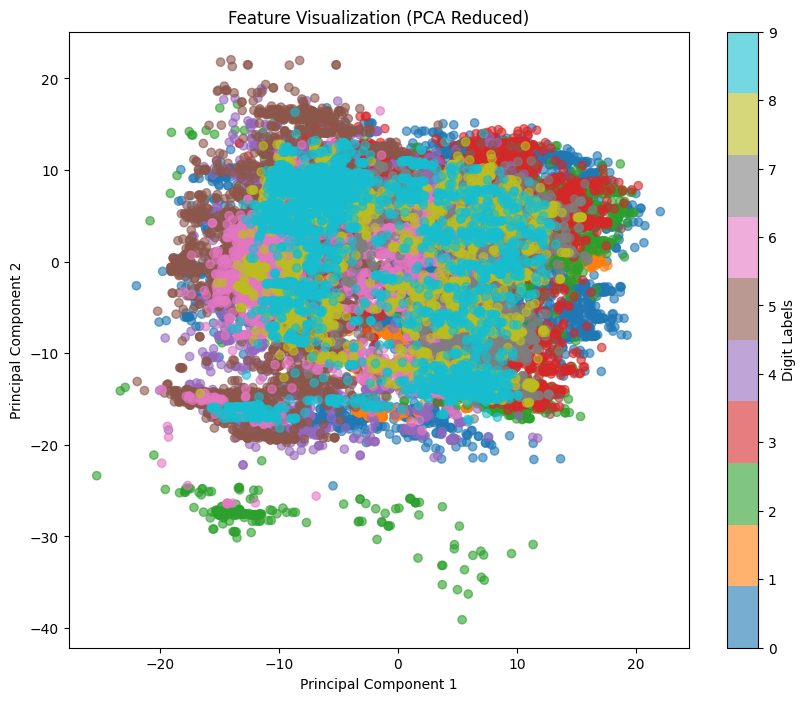

In [234]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train_features)

# Plot the reduced features with their true labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=train_labels, cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label="Digit Labels")
plt.title("Feature Visualization (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()